In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from tqdm import tqdm
import torch
import wandb
from datetime import datetime
import yaml
import os
import shutil
from data.dataloader import load_data
from model.network import create_model, cri_opt_sch
from model.utils import train_pt, validate_pt, train_ft, validate_ft, load_pretrained
from wordcloud import WordCloud
import matplotlib.pyplot as plt

c:\Users\619ar\anaconda3\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}\n')

Device: cuda



In [3]:
config = yaml.load(open('./config.yaml', 'r'), Loader=yaml.FullLoader)
config['device'] = device
model = create_model(config)
if config['stage'] == 'finetune' and config['load_pretrained']:
    load_pretrained(model, config['paths']['pretrained'])
    
weights_path = r"checkpoints\finetune\finetune-1128_2303\model.pt"
model.load_state_dict(torch.load(weights_path)['model_state_dict'], strict=False)

Pretrained Checkpoint Loaded


<All keys matched successfully>

In [4]:
from torch.utils.data import ConcatDataset
train_data_loader, val_data_loader = load_data(config)

==============================        DATA        ==============================
Batch size:  1
Train dataset samples:  619
Validation dataset samples:  110
Train dataset batches:  619
Validataion dataset batches:  110



In [5]:
model.eval()
all_targets = []
all_predictions = []

for batch in tqdm(val_data_loader):
    ids = batch['ids'].to(device)
    attention_mask = batch['mask'].to(device)
    target = batch['target'].to(device)

    with torch.inference_mode():
        output = model(ids, attention_mask=attention_mask).squeeze()

    all_targets.extend(target.cpu().numpy())
    all_predictions.append(output.cpu().item())

100%|██████████| 110/110 [00:04<00:00, 25.81it/s]


In [6]:
from sklearn.metrics import r2_score
r2 = r2_score(all_targets, all_predictions)
print(f'R2 score: {r2}')

R2 score: 0.9943682621774056


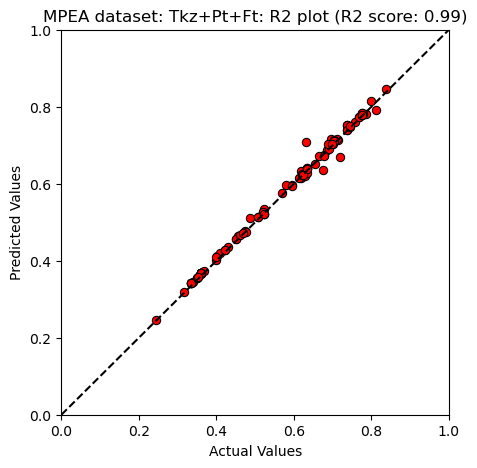

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(all_targets, all_predictions, c='red', edgecolors='black', linewidths=0.75)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'MPEA dataset: Tkz+Pt+Ft: R2 plot (R2 score: {r2:.2f})')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.savefig('r2_MPEA_tkz_pt_ft.png')
plt.show()